# Complete pipeline

In [1]:
from inf_functions import *
from class_functions import *
import matplotlib.pyplot as plt
import sklearn
import os 

os.environ['CUDA_VISIBLE_DEVICES']='1'
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

root_dir = "/home/alberto_sinigaglia/gaia"

2025-11-05 15:11:04.621142: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


1 Physical GPUs, 1 Logical GPUs


I0000 00:00:1762351867.512267 1138806 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 44560 MB memory:  -> device: 0, name: NVIDIA RTX A6000, pci bus id: 0000:41:00.0, compute capability: 8.6


In [2]:
with np.load('/home/alberto_sinigaglia/gaia/inference.npz', allow_pickle=True) as data:
    X = data["X"]
    y = data["y"]
    paths = data["paths"]

X, y = np.array(X), np.array(y)

## Low mass

In [ ]:
mass_range = 'CNN_low_mass'

data, label, path = X[0], y[0], paths[0]
data = data.reshape((1,6144,1))

print('Selected example:', path)

Selected example: /home/alberto_sinigaglia/gaia/CNN_low_mass/Test/Signal/mass1-16_mass2-25_sample8.hdf


### 1. Classification 

In [4]:
class_model_path = f"class_models/{mass_range}_best_model.keras"
class_model = tf.keras.models.load_model(class_model_path)

pred = class_model.predict(data)
label = (pred > 0.4).astype(int)

if label==1:
    print('The selected strain corresponds to a GW event.')
else:
    print('The selected strain corresponds to a noise event.')

2025-11-03 12:45:51.579998: I external/local_xla/xla/service/service.cc:163] XLA service 0x77d40800f230 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-11-03 12:45:51.580025: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2025-11-03 12:45:51.611011: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-11-03 12:45:51.655535: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91400


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 795ms/step
The selected strain corresponds to a GW event.


I0000 00:00:1762170352.201830  369571 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


### 2. Regression

Then, we infere the chirp mass and mass ratio.

In [ ]:
# we need the scaler 
with np.load(f"{root_dir}/{mass_range}_test.npz", allow_pickle=True) as dataset:
    X_test = dataset["X"]
    y_test = dataset["y"]

mask = y_test[:,0] == 1
X_test, y_test= X_test[mask], y_test[mask]

_, test_scaler = make_dataset(X_test, y_test, classification=False, batch_size=64, shuffle=False)

In [6]:
filename = path.split('/')[-1]
parts = filename.replace('.hdf', '').split('_') 
m1_true = float(parts[0].split('-')[1])
m2_true = float(parts[1].split('-')[1])

if m1_true < m2_true:
    m1_true, m2_true = m2_true, m1_true

reg_model_path = f"reg_models/{mass_range}_best_model.keras"
reg_model = tf.keras.models.load_model(reg_model_path)

y_pred = reg_model.predict(data)
y_pred = test_scaler.inverse_transform(y_pred)

M_cnn = y_pred[0][0]
q_cnn = y_pred[0][1]
M_err = 1.63

print(f"True parameters: m1 = {m1_true}, m2 = {m2_true}, q = {m2_true/m1_true:.2f}, M = {(m1_true*m2_true)**(3/5)/(m1_true+m2_true)**(1/5):.2f}")
print(f"CNN predicted parameters: q = {q_cnn:.2f}, M = {M_cnn:.2f}")
print(f"RMSE on chirp mass prediction: {M_err:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 533ms/step
True parameters: m1 = 25.0, m2 = 16.0, q = 0.64, M = 17.33
CNN predicted parameters: q = 0.62, M = 16.41
RMSE on chirp mass prediction: 1.63


### 3. Parameter inference

100%|██████████| 53000/53000 [00:00<00:00, 165909.96it/s]


MCMC for m1:
  Mean: 23.94 M☉
  Median: 23.93 M☉
  Std: 2.39 M☉


100%|██████████| 53000/53000 [00:00<00:00, 166996.16it/s]


MCMC for m2:
  Mean: 15.01 M☉
  Median: 15.00 M☉
  Std: 1.48 M☉


/home/alberto_sinigaglia/gaia/thesis/inf_functions.py:198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


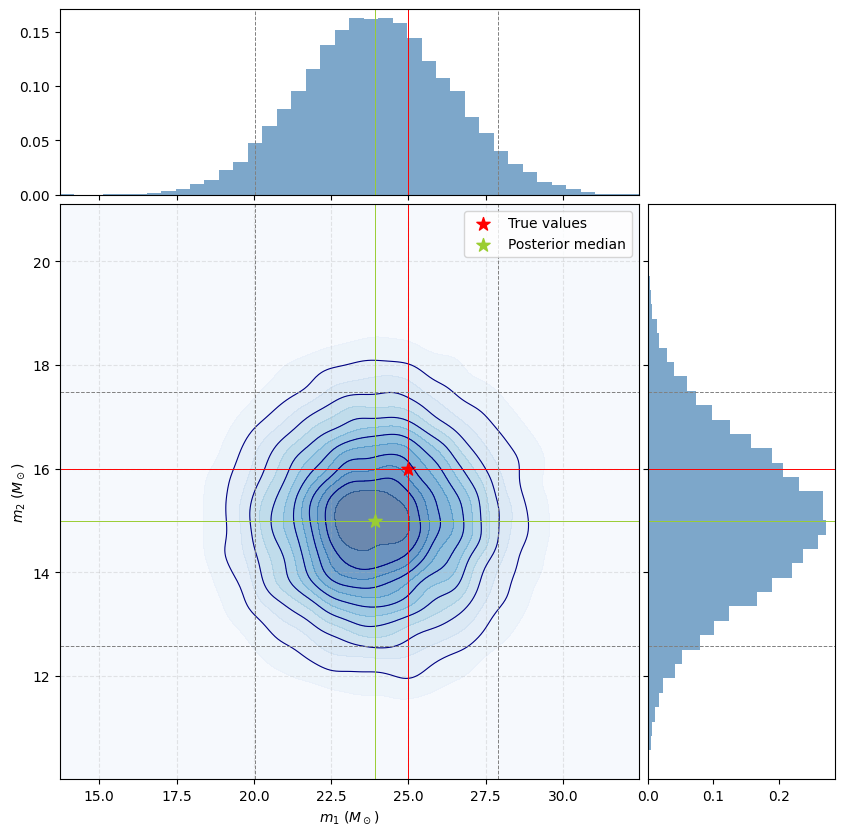

In [ ]:
m1_chain = MCMC(M_cnn, M_err, q_cnn, 'm1', seed=42)
m2_chain = MCMC(M_cnn, M_err, q_cnn, 'm2', seed=43)

plot_posteriors(m1_chain, m2_chain, m1_true, m2_true)

## Mid Mass I

In [8]:
root_dir = "/home/alberto_sinigaglia/gaia"
mass_range = 'CNN_mid_mass_I'

data, label, path = X[1], y[1], paths[1]
data = data.reshape((1,6144,1))

print('Selected example:', path)

Selected example: /home/alberto_sinigaglia/gaia/CNN_mid_mass_I/Test/Signal/mass1-44_mass2-33_sample8.hdf


### 1. Classification

In [9]:
class_model_path = f"class_models/{mass_range}_best_model.keras"
class_model = tf.keras.models.load_model(class_model_path)

pred = class_model.predict(data)
label = (pred > 0.4).astype(int)

if label==1:
    print('The selected strain corresponds to a GW event.')
else:
    print('The selected strain corresponds to a noise event.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 548ms/step
The selected strain corresponds to a GW event.


### 2. Regression

In [10]:
# we need the scaler 
with np.load(f"{root_dir}/{mass_range}_test.npz", allow_pickle=True) as dataset:
    X_test = dataset["X"]
    y_test = dataset["y"]

mask = y_test[:,0] == 1
X_test, y_test= X_test[mask], y_test[mask]

_, test_scaler = make_dataset(X_test, y_test, classification=False, batch_size=64, shuffle=False)

In [11]:
filename = path.split('/')[-1]
parts = filename.replace('.hdf', '').split('_') 
m1_true = float(parts[0].split('-')[1])
m2_true = float(parts[1].split('-')[1])

if m1_true < m2_true:
    m1_true, m2_true = m2_true, m1_true

reg_model_path = f"reg_models/{mass_range}_best_model.keras"
reg_model = tf.keras.models.load_model(reg_model_path)

y_pred = reg_model.predict(data)
y_pred = test_scaler.inverse_transform(y_pred)

M_cnn = y_pred[0][0]
q_cnn = y_pred[0][1]
M_err = 2.57

print(f"True parameters: m1 = {m1_true}, m2 = {m2_true}, q = {m2_true/m1_true:.2f}, M = {(m1_true*m2_true)**(3/5)/(m1_true+m2_true)**(1/5):.2f}")
print(f"CNN predicted parameters: q = {q_cnn:.2f}, M = {M_cnn:.2f}")
print(f"RMSE on chirp mass prediction: {M_err:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 524ms/step
True parameters: m1 = 44.0, m2 = 33.0, q = 0.75, M = 33.10
CNN predicted parameters: q = 0.83, M = 34.21
RMSE on chirp mass prediction: 2.57


### 3. Parameter inference

100%|██████████| 53000/53000 [00:00<00:00, 166589.19it/s]


MCMC for m1:
  Mean: 43.16 M☉
  Median: 43.17 M☉
  Std: 3.23 M☉


100%|██████████| 53000/53000 [00:00<00:00, 159026.54it/s]


MCMC for m2:
  Mean: 35.86 M☉
  Median: 35.85 M☉
  Std: 2.68 M☉


/home/alberto_sinigaglia/gaia/thesis/inf_functions.py:198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


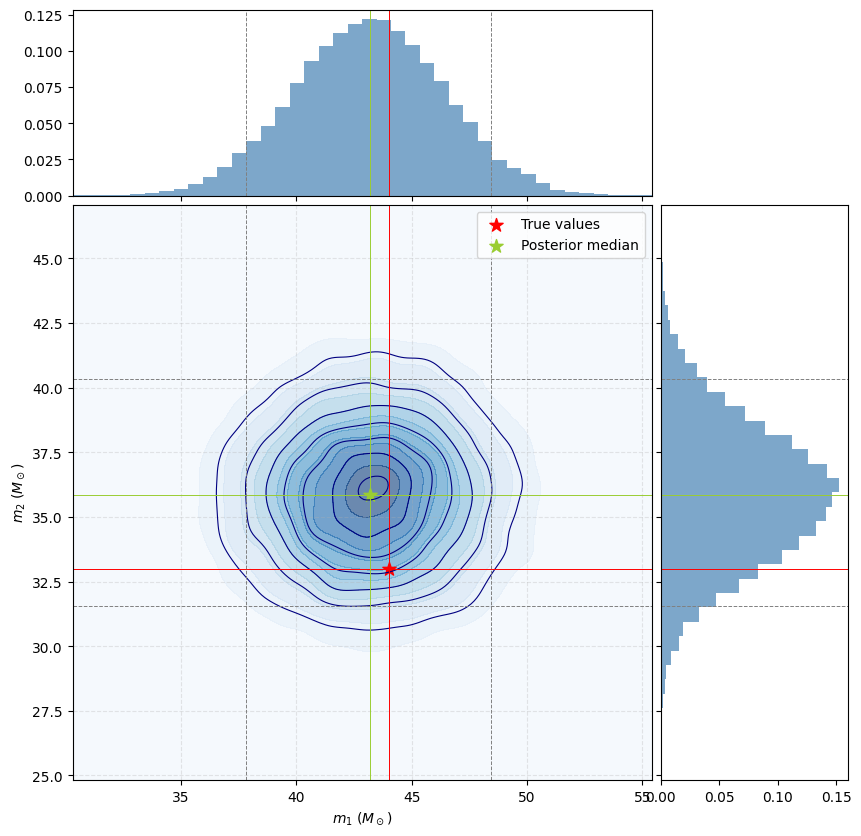

In [12]:
m1_chain = MCMC(M_cnn, M_err, q_cnn, 'm1', seed=42)
m2_chain = MCMC(M_cnn, M_err, q_cnn, 'm2', seed=43)

plot_posteriors(m1_chain, m2_chain, m1_true, m2_true)

## Mid mass II

In [13]:
root_dir = "/home/alberto_sinigaglia/gaia"
mass_range = 'CNN_mid_mass_II'

data, label, path = X[2], y[2], paths[2]
data = data.reshape((1,6144,1))

print('Selected example:', path)

Selected example: /home/alberto_sinigaglia/gaia/CNN_mid_mass_II/Test/Signal/mass1-68_mass2-53_sample1.hdf


### 1. Classification

In [14]:
class_model_path = f"class_models/{mass_range}_best_model.keras"
class_model = tf.keras.models.load_model(class_model_path)

pred = class_model.predict(data)
label = (pred > 0.4).astype(int)

if label==1:
    print('The selected strain corresponds to a GW event.')
else:
    print('The selected strain corresponds to a noise event.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step
The selected strain corresponds to a GW event.


### 2. Regression

In [15]:
# we need the scaler 
with np.load(f"{root_dir}/{mass_range}_test.npz", allow_pickle=True) as dataset:
    X_test = dataset["X"]
    y_test = dataset["y"]

mask = y_test[:,0] == 1
X_test, y_test= X_test[mask], y_test[mask]

_, test_scaler = make_dataset(X_test, y_test, classification=False, batch_size=64, shuffle=False)

In [16]:
filename = path.split('/')[-1]
parts = filename.replace('.hdf', '').split('_') 
m1_true = float(parts[0].split('-')[1])
m2_true = float(parts[1].split('-')[1])

if m1_true < m2_true:
    m1_true, m2_true = m2_true, m1_true

reg_model_path = f"reg_models/{mass_range}_best_model.keras"
reg_model = tf.keras.models.load_model(reg_model_path)

y_pred = reg_model.predict(data)
y_pred = test_scaler.inverse_transform(y_pred)

M_cnn = y_pred[0][0]
q_cnn = y_pred[0][1]
M_err = 2.72

print(f"True parameters: m1 = {m1_true}, m2 = {m2_true}, q = {m2_true/m1_true:.2f}, M = {(m1_true*m2_true)**(3/5)/(m1_true+m2_true)**(1/5):.2f}")
print(f"CNN predicted parameters: q = {q_cnn:.2f}, M = {M_cnn:.2f}")
print(f"RMSE on chirp mass prediction: {M_err:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 552ms/step
True parameters: m1 = 68.0, m2 = 53.0, q = 0.78, M = 52.18
CNN predicted parameters: q = 0.91, M = 56.69
RMSE on chirp mass prediction: 2.72


### 3. Parameter inference 

100%|██████████| 53000/53000 [00:00<00:00, 168012.58it/s]


MCMC for m1:
  Mean: 68.10 M☉
  Median: 68.13 M☉
  Std: 3.26 M☉


100%|██████████| 53000/53000 [00:00<00:00, 168909.78it/s]


MCMC for m2:
  Mean: 62.32 M☉
  Median: 62.29 M☉
  Std: 2.97 M☉


/home/alberto_sinigaglia/gaia/thesis/inf_functions.py:198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


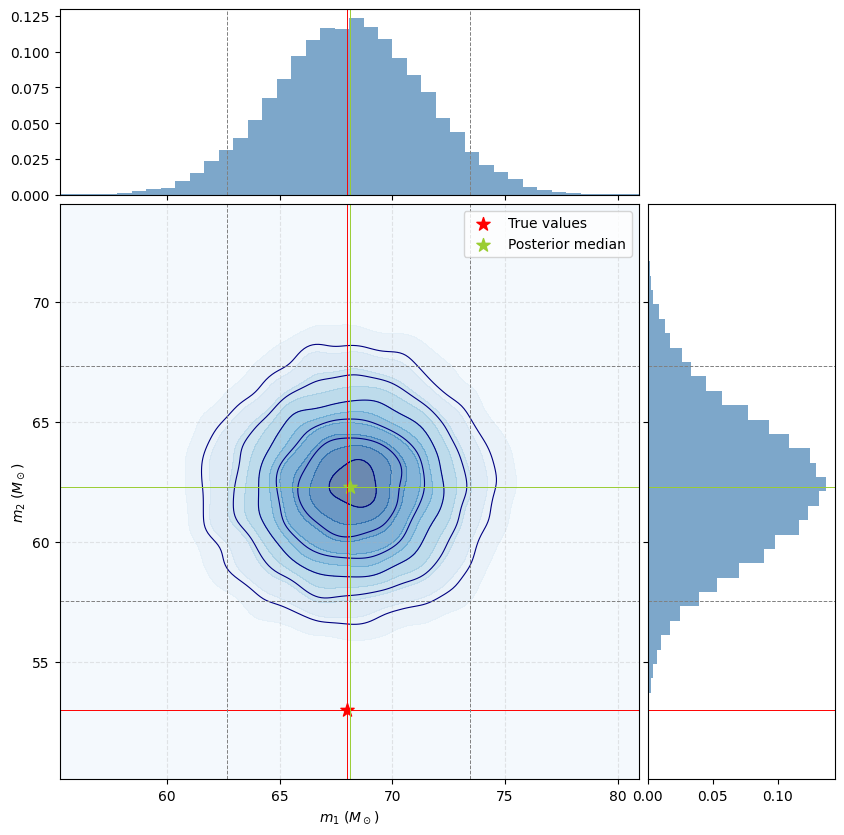

In [17]:
m1_chain = MCMC(M_cnn, M_err, q_cnn, 'm1', seed=42)
m2_chain = MCMC(M_cnn, M_err, q_cnn, 'm2', seed=43)

plot_posteriors(m1_chain, m2_chain, m1_true, m2_true)

## High mass

In [18]:
root_dir = "/home/alberto_sinigaglia/gaia"
mass_range = 'CNN_high_mass'

data, label, path = X[3], y[3], paths[3]
data = data.reshape((1,6144,1))

print('Selected example:', path)

Selected example: /home/alberto_sinigaglia/gaia/CNN_high_mass/Test/Signal/mass1-77_mass2-83_sample7.hdf


### 1. Classification

In [19]:
class_model_path = f"class_models/{mass_range}_best_model.keras"
class_model = tf.keras.models.load_model(class_model_path)

pred = class_model.predict(data)
label = (pred > 0.4).astype(int)

if label==1:
    print('The selected strain corresponds to a GW event.')
else:
    print('The selected strain corresponds to a noise event.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 541ms/step
The selected strain corresponds to a GW event.


### 2. Regression

In [20]:
# we need the scaler 
with np.load(f"{root_dir}/{mass_range}_test.npz", allow_pickle=True) as dataset:
    X_test = dataset["X"]
    y_test = dataset["y"]

mask = y_test[:,0] == 1
X_test, y_test= X_test[mask], y_test[mask]

_, test_scaler = make_dataset(X_test, y_test, classification=False, batch_size=64, shuffle=False)

In [21]:
filename = path.split('/')[-1]
parts = filename.replace('.hdf', '').split('_') 
m1_true = float(parts[0].split('-')[1])
m2_true = float(parts[1].split('-')[1])

if m1_true < m2_true:
    m1_true, m2_true = m2_true, m1_true

reg_model_path = f"reg_models/{mass_range}_best_model.keras"
reg_model = tf.keras.models.load_model(reg_model_path)

y_pred = reg_model.predict(data)
y_pred = test_scaler.inverse_transform(y_pred)

M_cnn = y_pred[0][0]
q_cnn = y_pred[0][1]
M_err = 2.71

print(f"True parameters: m1 = {m1_true}, m2 = {m2_true}, q = {m2_true/m1_true:.2f}, M = {(m1_true*m2_true)**(3/5)/(m1_true+m2_true)**(1/5):.2f}")
print(f"CNN predicted parameters: q = {q_cnn:.2f}, M = {M_cnn:.2f}")
print(f"RMSE on chirp mass prediction: {M_err:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
True parameters: m1 = 83.0, m2 = 77.0, q = 0.93, M = 69.59
CNN predicted parameters: q = 0.89, M = 70.04
RMSE on chirp mass prediction: 2.71


### 3. Parameter inference 

100%|██████████| 53000/53000 [00:00<00:00, 163654.13it/s]


MCMC for m1:
  Mean: 84.76 M☉
  Median: 84.95 M☉
  Std: 2.86 M☉


100%|██████████| 53000/53000 [00:00<00:00, 166249.94it/s]


MCMC for m2:
  Mean: 75.98 M☉
  Median: 75.95 M☉
  Std: 2.93 M☉


/home/alberto_sinigaglia/gaia/thesis/inf_functions.py:198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


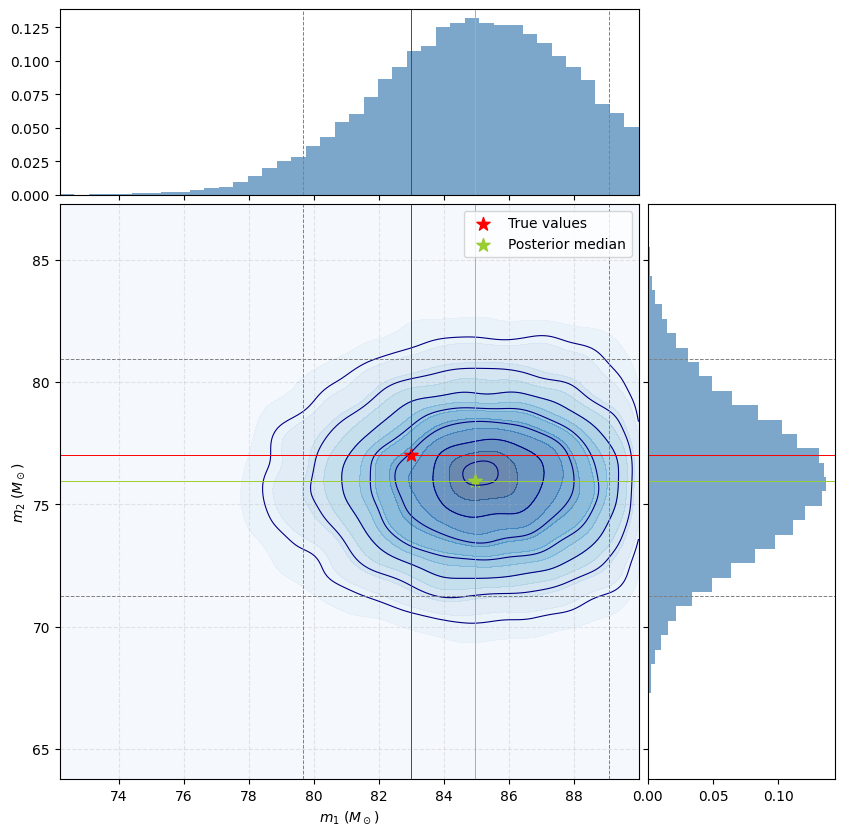

In [22]:
m1_chain = MCMC(M_cnn, M_err, q_cnn, 'm1', seed=42)
m2_chain = MCMC(M_cnn, M_err, q_cnn, 'm2', seed=43)

plot_posteriors(m1_chain, m2_chain, m1_true, m2_true)

## Real data

In [12]:
with np.load('/home/alberto_sinigaglia/gaia/real_data.npz', allow_pickle=True) as data:
    X = data["X"]
    y = data["y"]
    m_range = data['mass_range']
    names = data['name']
    masses = data['m']

## Low mass event : GW190408 

In [ ]:
mass_range = 'CNN_low_mass'

X_low = np.array(X[m_range == 'low_mass'])
y_low = np.array(y[m_range == 'low_mass'])
names_low = names[m_range == 'low_mass']
masses_low = masses[m_range == 'low_mass']

idx = 4
data = X_low[idx].reshape((1,6144,1))
y = y_low[idx]

print(f'Working with the event {names_low[idx]}')

Working with the event GW190408_181802-v2


### 1. Classification

In [75]:
class_model_path = f"class_models/{mass_range}_best_model.keras"
class_model = tf.keras.models.load_model(class_model_path)

pred = class_model.predict(data)
label = (pred > 0.4).astype(int)

if label==1:
    print('The selected strain corresponds to a GW event.')
else:
    print('The selected strain corresponds to a noise event.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
The selected strain corresponds to a noise event.


### 2. Regression

In [76]:
# we need the scaler 
with np.load(f"{root_dir}/{mass_range}_test.npz", allow_pickle=True) as dataset:
    X_test = dataset["X"]
    y_test = dataset["y"]

mask = y_test[:,0] == 1
X_test, y_test= X_test[mask], y_test[mask]

_, test_scaler = make_dataset(X_test, y_test, classification=False, batch_size=64, shuffle=False)

In [78]:
m1_true = masses_low[idx][0]
m2_true = masses_low[idx][1]

if m1_true < m2_true:
    m1_true, m2_true = m2_true, m1_true

reg_model_path = f"reg_models/{mass_range}_best_model.keras"
reg_model = tf.keras.models.load_model(reg_model_path)

y_pred = reg_model.predict(data)
y_pred = test_scaler.inverse_transform(y_pred)

M_cnn = y_pred[0][0]
q_cnn = y_pred[0][1]
M_err = 1.63

print(f"True parameters: m1 = {m1_true}, m2 = {m2_true}, q = {m2_true/m1_true:.2f}, M = {(m1_true*m2_true)**(3/5)/(m1_true+m2_true)**(1/5):.2f}")
print(f"CNN predicted parameters: q = {q_cnn:.2f}, M = {M_cnn:.2f}")
print(f"RMSE on chirp mass prediction: {M_err:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
True parameters: m1 = 24.8, m2 = 18.5, q = 0.75, M = 18.61
CNN predicted parameters: q = 0.68, M = 18.48
RMSE on chirp mass prediction: 1.63


### 3. Parameter inference

100%|██████████| 53000/53000 [00:00<00:00, 73271.48it/s]


MCMC for m1:
  Mean: 25.78 M☉
  Median: 25.78 M☉
  Std: 2.28 M☉


100%|██████████| 53000/53000 [00:00<00:00, 75106.09it/s]


MCMC for m2:
  Mean: 17.63 M☉
  Median: 17.63 M☉
  Std: 1.55 M☉


/home/alberto_sinigaglia/gaia/thesis/inf_functions.py:198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


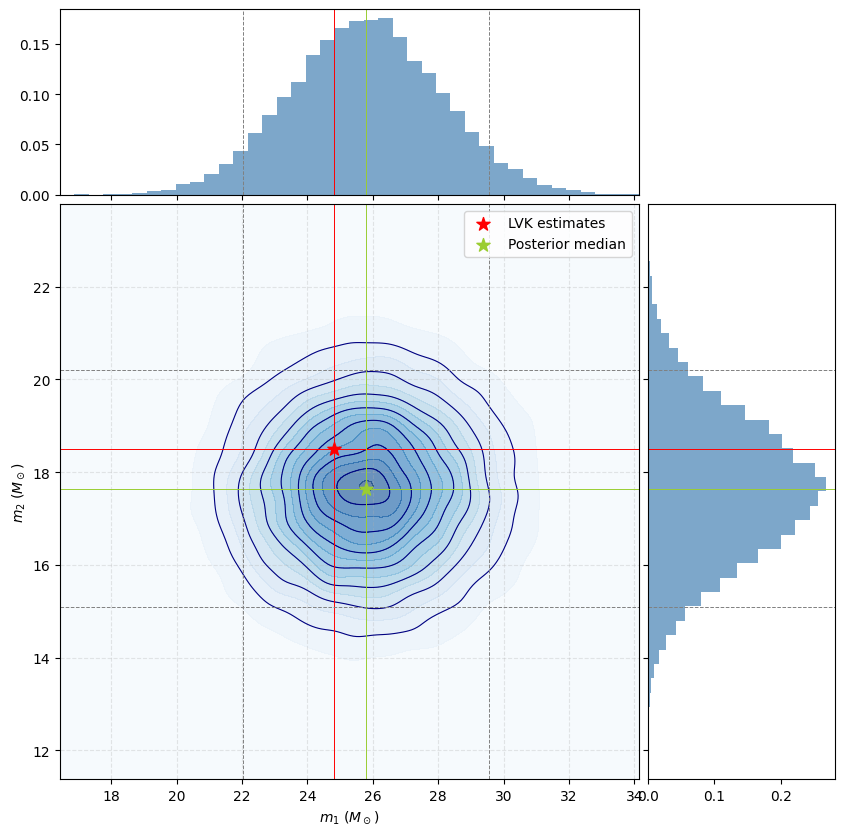

In [79]:
m1_chain = MCMC(M_cnn, M_err, q_cnn, 'm1', seed=42)
m2_chain = MCMC(M_cnn, M_err, q_cnn, 'm2', seed=43)

plot_posteriors(m1_chain, m2_chain, m1_true, m2_true, synthetic=False)

## Mid mass I event: GW190910

In [13]:
mass_range = 'CNN_mid_mass_I'

X_mid = np.array(X[m_range == 'mid_mass_I'])
y_mid = np.array(y[m_range == 'mid_mass_I'])
names_mid = names[m_range == 'mid_mass_I']
masses_mid = masses[m_range == 'mid_mass_I']

In [19]:
idx = 0 
data = X_mid[idx].reshape((1,6144,1))
y = y_mid[idx]

print(f'Working with the event {names_mid[idx]}')

Working with the event GW190910_112807-v2


In [20]:
class_model_path = f"class_models/{mass_range}_best_model.keras"
class_model = tf.keras.models.load_model(class_model_path)

pred = class_model.predict(data)
label = (pred > 0.4).astype(int)

if label==1:
    print('The selected strain corresponds to a GW event.')
else:
    print('The selected strain corresponds to a noise event.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 901ms/step
The selected strain corresponds to a GW event.


In [84]:
# we need the scaler 
with np.load(f"{root_dir}/{mass_range}_test.npz", allow_pickle=True) as dataset:
    X_test = dataset["X"]
    y_test = dataset["y"]

mask = y_test[:,0] == 1
X_test, y_test= X_test[mask], y_test[mask]

_, test_scaler = make_dataset(X_test, y_test, classification=False, batch_size=64, shuffle=False)

In [85]:
m1_true = masses_mid[idx][0]
m2_true = masses_mid[idx][1]

if m1_true < m2_true:
    m1_true, m2_true = m2_true, m1_true

reg_model_path = f"reg_models/{mass_range}_best_model.keras"
reg_model = tf.keras.models.load_model(reg_model_path)

y_pred = reg_model.predict(data)
y_pred = test_scaler.inverse_transform(y_pred)

M_cnn = y_pred[0][0]
q_cnn = y_pred[0][1]
M_err = 1.63

print(f"True parameters: m1 = {m1_true}, m2 = {m2_true}, q = {m2_true/m1_true:.2f}, M = {(m1_true*m2_true)**(3/5)/(m1_true+m2_true)**(1/5):.2f}")
print(f"CNN predicted parameters: q = {q_cnn:.2f}, M = {M_cnn:.2f}")
print(f"RMSE on chirp mass prediction: {M_err:.2f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 922ms/step
True parameters: m1 = 43.8, m2 = 34.2, q = 0.78, M = 33.64
CNN predicted parameters: q = 0.83, M = 34.06
RMSE on chirp mass prediction: 1.63


100%|██████████| 53000/53000 [00:00<00:00, 82791.36it/s]


MCMC for m1:
  Mean: 43.03 M☉
  Median: 43.04 M☉
  Std: 2.08 M☉


100%|██████████| 53000/53000 [00:00<00:00, 81658.74it/s]


MCMC for m2:
  Mean: 35.67 M☉
  Median: 35.67 M☉
  Std: 1.70 M☉


/home/alberto_sinigaglia/gaia/thesis/inf_functions.py:198: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


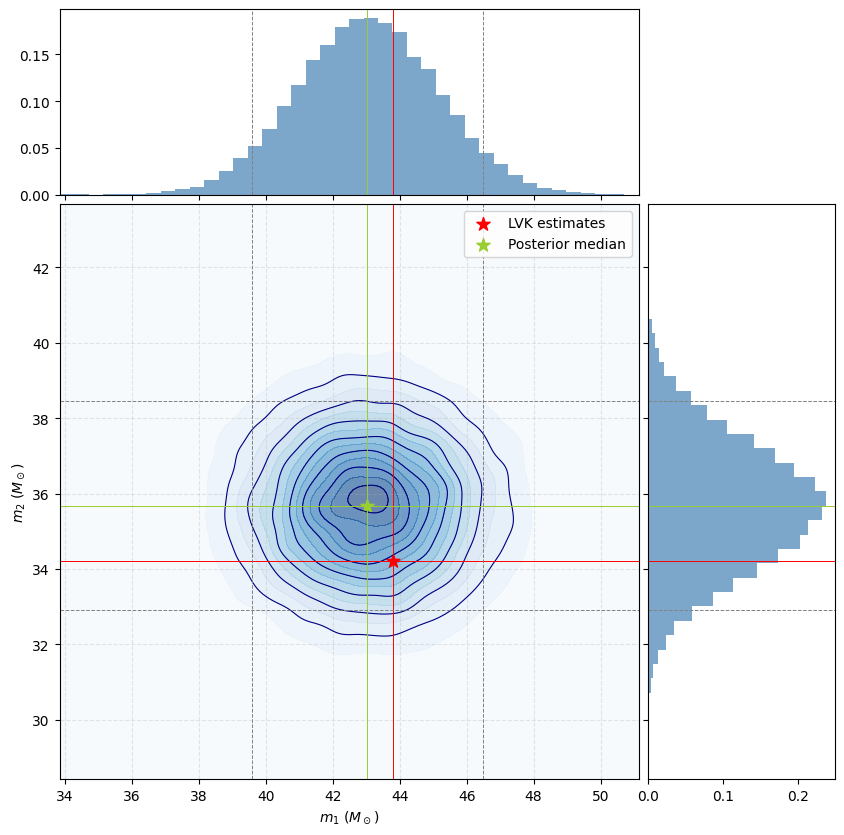

In [86]:
m1_chain = MCMC(M_cnn, M_err, q_cnn, 'm1', seed=42)
m2_chain = MCMC(M_cnn, M_err, q_cnn, 'm2', seed=43)

plot_posteriors(m1_chain, m2_chain, m1_true, m2_true, synthetic=False)